# Homework 2
In this homework we will implement the Apriori algorithm to find frequent itemsets in a dataset of baskets. We will use the algorithm to find association rules between items in the baskets.

## Read the data
First of all, we need to get the data. The data can be found [here](https://canvas.kth.se/courses/42990/files/6945385/download?wrap=1). We will put it in memory as a list of sets, where each list represents a row in the data.
We get each basket that it is a row. Each basket is a set of items

In [4]:
baskets: list[set[int]] = []
filename: str = 'T10I4D100K.dat'
with open(filename, 'r') as f:
    for line in f:
        baskets.append(set(map(int, line.split())))
print(f'Loaded {len(baskets)} baskets from {filename}')

Loaded 100000 baskets from T10I4D100K.dat


After we have loaded the baskets, we need to find the frequent itemsets. We will use a naive approach first and then we will improve it with the Apriori algorithm.

## Apriori Algorithm
The Apriori algorithm is a more efficient way to find the frequent itemsets. The idea is to use the fact that if an itemset is frequent, then all its subsets are frequent. This means that we can prune the search space by removing all the itemsets that have an infrequent subset.

In [5]:
from collections import Counter
from itertools import combinations
import time

def apriori(
        baskets: list[set[int]],
        min_support: int,
        verbose: bool = False,
    ) -> dict[tuple, int]:
    total_freq_itemsets = dict()
    frequent_itemsets = find_frequent_itemsets(baskets, 1, min_support)
    total_freq_itemsets.update(frequent_itemsets)
    frequent_itemsets = set([itemset[0] for itemset in frequent_itemsets])
    if verbose:
        print(f'Found {len(frequent_itemsets)} frequent 1-itemsets')
    k = 2
    while frequent_itemsets:
        frequent_itemsets = find_frequent_itemsets(baskets, k, min_support, frequent_itemsets)
        total_freq_itemsets.update(frequent_itemsets)
        frequent_itemsets = set([itemset for itemset in frequent_itemsets])
        k += 1
        if verbose:
            print(f'Found {len(frequent_itemsets)} frequent {k-1}-itemsets')

    return total_freq_itemsets

def find_frequent_itemsets(
        baskets: list[set[int]], 
        k: int = 1,
        min_support: int = 0,
        frequent_itemsets: list[tuple] = list(),
    ) -> list[tuple]:
    if k == 1:
        candidate_itemsets = {tuple([item]) for item in set.union(*baskets)}
    else:
        candidate_itemsets = generate_candidate_itemsets(frequent_itemsets, k)
    frequent_itemsets: set = filter_freq_itemsets(baskets, candidate_itemsets, min_support, k)
    return frequent_itemsets

def generate_candidate_itemsets(
        frequent_itemsets: set[tuple],
        k: int = 1,
    ) -> set[tuple]:
    if k == 1:
        return {tuple([item]) for item in set.union(*frequent_itemsets)}
    return set(combinations(frequent_itemsets, k))

def filter_freq_itemsets(
        baskets: list[set[int]], 
        candidate_itemsets: set[tuple],
        min_support: int = 0,
        k: int = 1,
    ) -> dict[tuple, int]:
    itemset_counts = Counter(
        [
            itemset
            for basket in baskets
            for itemset in combinations(basket, k)
            if itemset in candidate_itemsets
        ]
    )

    return {itemset: count for itemset, count in itemset_counts.items() if count > min_support}


Let's try the functions we created before with the buckets. We want a support level of 1000 appearances in the baskets.

In [6]:
freq_itemsets = apriori(baskets, 1000, verbose=True)
print(f'Found in total {len(freq_itemsets)} frequent itemsets')

Found 375 frequent 1-itemsets
Found 5 frequent 2-itemsets
Found 0 frequent 3-itemsets
Found in total 380 frequent itemsets


Now, let's check the performance compared to the number of appearances in the baskets.

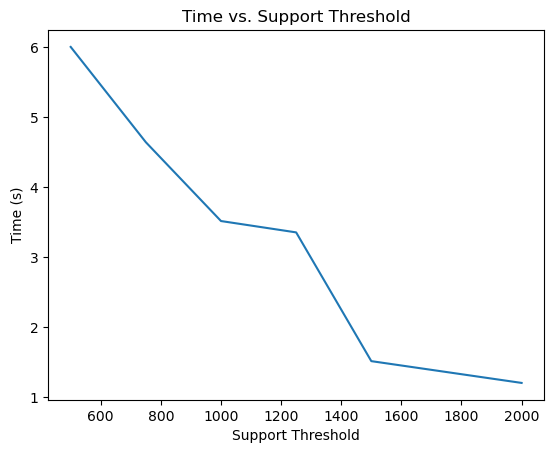

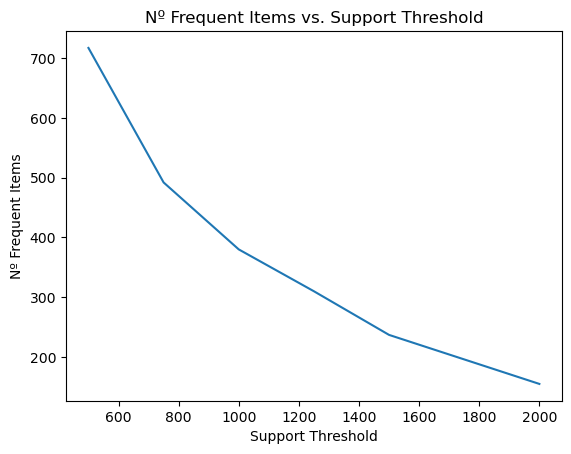

In [7]:
import matplotlib.pyplot as plt
supports = [500, 750, 1000, 1250, 1500, 2000]
durations = []
n_freq_items = []

for support in supports:
  start = time.time()
  freq_items = apriori(baskets, support)
  duration = time.time() - start
  
  durations.append(duration)
  n_freq_items.append(len(freq_items))


plt.plot(supports, durations)
plt.xlabel('Support Threshold')
plt.ylabel('Time (s)')
plt.title('Time vs. Support Threshold')
plt.show()

plt.plot(supports, n_freq_items)
plt.xlabel('Support Threshold')
plt.ylabel('Nº Frequent Items')
plt.title('Nº Frequent Items vs. Support Threshold')
plt.show()

## Association Rules
Now that we have the frequent itemsets, we can find the association rules. We will use the confidence metric to find the rules. The confidence of a rule is the support of the itemset divided by the support of the antecedent. We will use a threshold of 0.5. It can be applied to (a,b) -> c. 

In [8]:
def generate_rules(
        freq_itemsets: dict[tuple, int],
        min_confidence: float = 0.5,
    ) -> list[tuple]:
    rules = []
    for itemset in freq_itemsets:
        if len(itemset) == 1:
            continue
        for item in itemset:
            itemset_minus_item = tuple(sorted(set(itemset) - {item}))
            confidence = (
                freq_itemsets[itemset] / freq_itemsets[itemset_minus_item]
                if itemset_minus_item
                else 1
            )
            if confidence >= min_confidence:
                rules.append((itemset_minus_item, itemset, confidence))
    return rules

(704,) => (704, 825) (confidence: 0.60)
(227,) => (227, 390) (confidence: 0.56)


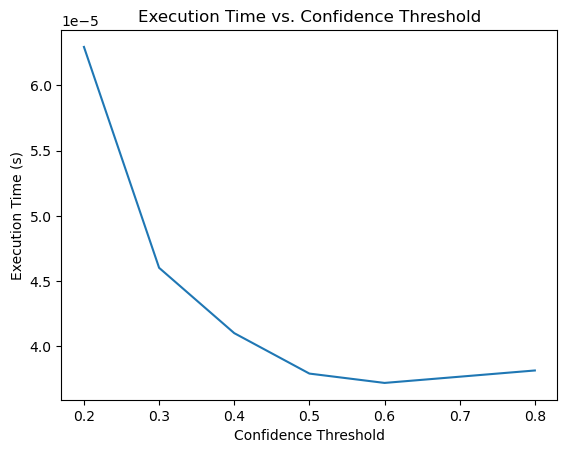

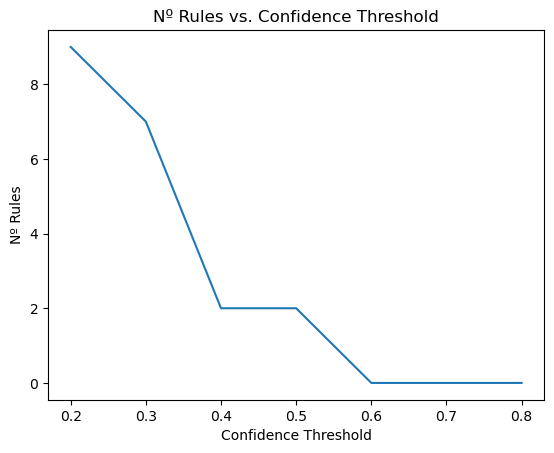

In [9]:
freq_items = apriori(baskets, 1000)
rules = generate_rules(freq_items, 0.5)
for rule in rules:
    print(f'{rule[0]} => {rule[1]} (confidence: {rule[2]:.2f})')

confidences = [0.2, 0.3, 0.4, 0.5, 0.6, 0.8]
durations = []
n_rules = []

for confidence in confidences:
  start = time.time()
  rules = generate_rules(freq_items, confidence)
  duration = time.time() - start
  
  durations.append(duration)
  n_rules.append(len(rules))

plt.plot(confidences, durations)
plt.xlabel('Confidence Threshold')
plt.ylabel('Execution Time (s)')
plt.title('Execution Time vs. Confidence Threshold')
plt.show()



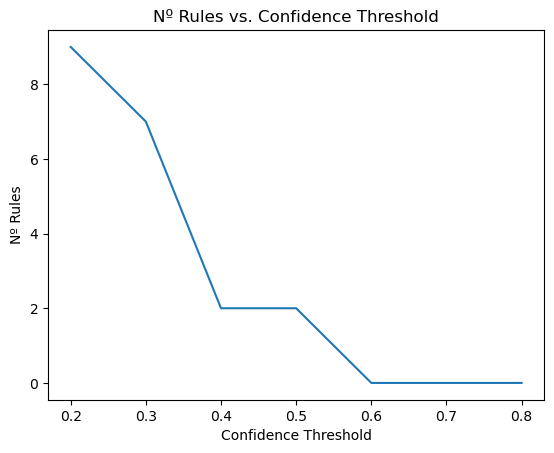

In [10]:
plt.plot(confidences, n_rules)
plt.xlabel('Confidence Threshold')
plt.ylabel('Nº Rules')
plt.title('Nº Rules vs. Confidence Threshold')
plt.show()